In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [0]:
# creating minibatches
def mini_batch(X, size):
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, 28, 28, 1)
    
    return x_bat

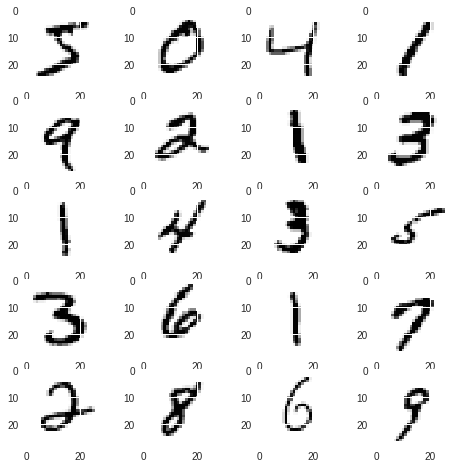

In [14]:
(x_train,_), (x_test, _) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

# plotting images
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[j])
    j+=1
    
plt.show()

In [15]:
# preparing training and test set
x_train = x_train.reshape(len(x_train),  28,  28,  1).astype(np.float32)
x_test = x_test.reshape(len(x_test),  28,  28,  1).astype(np.float32)
print("training data: ", x_train.shape)
print("testing data : ", x_test.shape)

# batch size
batch = 50

training data:  (60000, 28, 28, 1)
testing data :  (10000, 28, 28, 1)


In [0]:
class vae:    
    def __init__(self, batch_size):
        """
            batch_size: training or testing data batch size
            lr: Learning rate
        """
        self.batch_size = batch_size
        
    
    def GaussianSample(self, mu, sigma):
        """
            mu: vector of means
            sigma: vector of standard deviations
            
            returns vector e sampled from unit normal distribution and scaled to sigma and shifted to mu
        """
        
        e = tf.random_normal(shape=[self.batch_size, int(mu.shape[1])], mean=0., stddev=1.)
        
        sampled = mu + tf.multiply(tf.exp(sigma), e)
        
        return sampled
    
    
    
    # encoder model
    def encoder(self, x_in):
        """
            x_in: image input
            
            implements encoder model
        """
        
        en1 = tf.layers.conv2d(x_in, filters=16, kernel_size=(2,2), activation=tf.nn.relu, padding="same")
        en1 = tf.layers.max_pooling2d(en1, pool_size=(2,2), strides=(2,2))
        
        en2 = tf.layers.conv2d(en1, filters=32, kernel_size=(2,2), activation=tf.nn.relu, padding="same")
        en2 = tf.layers.max_pooling2d(en2, pool_size=(2,2), strides=(2,2))
        
        en3 = tf.layers.conv2d(en2, filters=64, kernel_size=(2,2), activation=tf.nn.relu, padding="same")
        en3 = tf.layers.max_pooling2d(en3, pool_size=(2,2), strides=(2,2))
            
        flat = tf.layers.flatten(en3)
        
        # vector of means
        mu = tf.layers.dense(flat, int(flat.shape[1]), activation=None)
        # vector of standard deviations
        sigma = tf.layers.dense(flat, int(flat.shape[1]), activation=None)
        
        z = self.GaussianSample(mu, sigma)
        
        print("Encoder")
        print("en1  : ", en1.shape)
        print("en2  : ", en2.shape)
        print("en3  : ", en3.shape)
        print("mu   : ", mu.shape)
        print("flat : ",flat.shape)
        print("sigma: ", sigma.shape)
        print("z    : ", z.shape)
        print()
        
        return tf.reshape(z, tf.shape(en3)), mu, sigma
    
    
    def decoder(self, latent):
        """
            latent: latent representation sampled from normal distribution
            
            returns P(x|z)
        """
        de1 = tf.layers.conv2d_transpose(latent, 64, kernel_size=(4,4), strides=(2,2), padding="same", kernel_initializer=tf.initializers.random_normal)
        de1 = tf.nn.relu(de1)
        
        de2 = tf.layers.conv2d_transpose(de1, 32, kernel_size=(4,4), strides=(2,2), padding="valid", kernel_initializer=tf.initializers.random_normal)
        de2 = tf.nn.relu(de2)
        
        de3 = tf.layers.conv2d_transpose(de2, 16, kernel_size=(4,4), strides=(2,2), padding="same", kernel_initializer=tf.initializers.random_normal)
        de3 = tf.nn.relu(de3)
        
        final = tf.layers.conv2d_transpose(de3, 1, kernel_size=(4,4), strides=(1,1), padding="same", kernel_initializer=tf.initializers.random_normal)
        
        print("Decoder")
        print("de1  : ",de1.shape)
        print("de2  : ",de2.shape)
        print("de3  : ",de3.shape)
        print("final: ",final.shape)
        print()
        
        return final
    
    
    def AutoencoderLoss(self, x, xhat, mean, log_stddev):
        """
            xhat: output from the decoder
            x: image input
            log_stddev: standard deviations from the encoder
            
            returns the reconstruction + KL divergence loss 
        """
        
        # reconstruction loss
        recon = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=xhat, labels=x))
        
        # KL divergence loss
        # KL( q(z|x) || N(mu, sigma) )
        KL_div = - 0.5 * tf.reduce_sum(1 + log_stddev - tf.square(mean) - tf.square(tf.exp(log_stddev)), axis=-1)
        
        final_loss = tf.reduce_mean(recon + KL_div)
        
        return final_loss

In [0]:
# placeholder for inputs
x_input = tf.placeholder(tf.float32, [batch, x_train.shape[1], x_train.shape[2], x_train.shape[3]])

# placeholder for ground truth images
x_output = tf.placeholder(tf.float32, [batch, x_train.shape[1], x_train.shape[2], x_train.shape[3]])

In [62]:
with tf.device("/gpu:0"):
    # initialising autoencoder model
    model = vae(batch_size = batch)

    Encoder, means, log_sigma = model.encoder(x_input)
    Decoder = model.decoder(Encoder)
    Cost = model.AutoencoderLoss(x_input, Decoder, means, log_sigma)

    # optimizing
    opt = tf.train.AdamOptimizer(0.005).minimize(Cost)

Encoder
en1  :  (50, 14, 14, 16)
en2  :  (50, 7, 7, 32)
en3  :  (50, 3, 3, 64)
mu   :  (50, 576)
flat :  (50, 576)
sigma:  (50, 576)
z    :  (50, 576)

Decoder
de1  :  (50, 6, 6, 64)
de2  :  (50, 14, 14, 32)
de3  :  (50, 28, 28, 16)
final:  (50, 28, 28, 1)



In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

epochs = 200

cost_list = []

for i in range(epochs):
    x_batch = mini_batch(x_train, batch)
    sess.run(opt, {x_input: x_batch})
    
    cost_list.append(sess.run(Cost, {x_input: x_batch}))

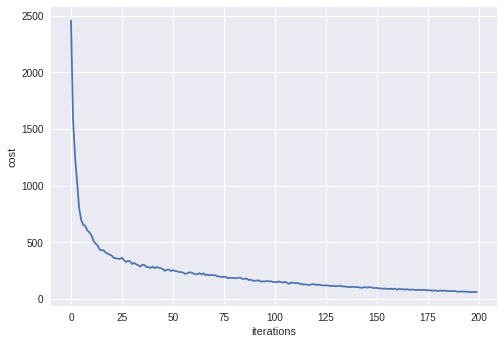

60.83995

In [68]:
plt.plot(range(0, len(cost_list)), cost_list)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.show()
cost_list[-1]

In [0]:
m = 0
std = 1

# placeholder for test input
test_input_ph = tf.placeholder(tf.float32, [batch, 3,3,20])
# sampling randomly from Gaussian distribution
test_input = np.random.normal(size=[batch, 3, 3, 20], loc=m, scale=std)

# get decoder output
test_decoder = Decoder
test_output = sess.run(test_decoder, {x_input: x_test[0:batch, :]})
test_output = np.clip(test_output, 0., 1.)

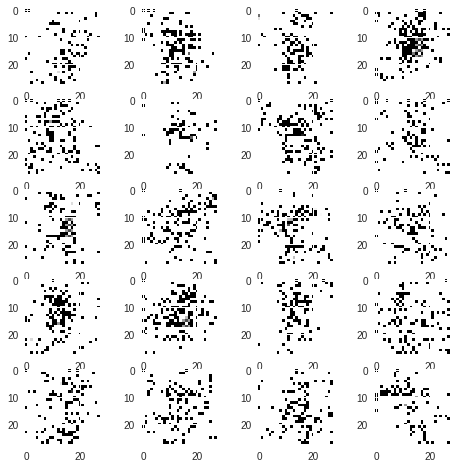

In [70]:
# to plot images reshape image array to [n, 28, 28]
test_output = test_output.reshape((test_output.shape[0], test_output.shape[1], test_output.shape[2])) 

# plotting reconstructed images
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
j = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(test_output[j])
    j+=1
    
plt.show()